# Life Satisfaction: Descriptive Statistics
Summaries of the `LifeSat` target from `data/lifesat_sdt_subset.csv`.

In [1]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../data/lifesat_sdt_subset.csv")
df = pd.read_csv(DATA_PATH)

lifesat = pd.to_numeric(df["LifeSat"], errors="coerce")
lifesat_summary = lifesat.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
lifesat_summary_df = lifesat_summary.to_frame(name="LifeSat").T
lifesat_value_counts = lifesat.value_counts(dropna=False).sort_index()

display(lifesat_summary_df)
display(lifesat_value_counts.to_frame(name="count"))

,count,mean,std,min,10%,25%,50%,75%,90%,max
LifeSat,95800.0,7.066409,2.237507,1.0,4.0,6.0,7.0,9.0,10.0,10.0


,count
LifeSat,
1.0,2596
2.0,1403
3.0,3103
4.0,4426
5.0,11383
6.0,10857
7.0,16234
8.0,19545
9.0,10038


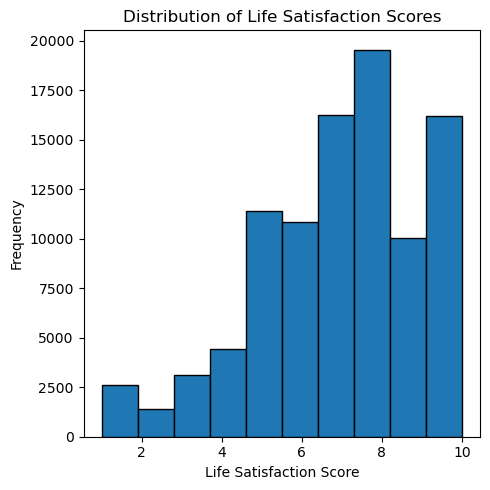

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
lifesat.plot(kind="hist", edgecolor="black")
plt.title("Distribution of Life Satisfaction Scores")
plt.xlabel("Life Satisfaction Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Recoding the predictors

Reverse the predictors so that a higher score means a higher value of the construct.

In [14]:
reversed_vars = [
    "SHealth",
    "RiskUnemployed",
    "EducationNextGen",
    "Security",
    "HumanRights",
    "Trust_Family",
    "Trust_Neighbors",
    "Trust_Acquaintances",
    "Trust_Strangers",
    "Trust_OtherReligion",
    "Trust_OtherNationality",
    "ReligiousAttendance",
    "Pray",
    "NationalPride",
    "CloseToTown",
    "CloseToRegion",
    "CloseToCountry",
    "CloseToContinent",
    "CloseToWorld",
]
df_reversed = df.copy()
missing_reverse: list[str] = []

for column in reversed_vars:
    if column not in df_reversed.columns:
        missing_reverse.append(column)
        continue
    numeric = pd.to_numeric(df_reversed[column], errors="coerce")
    col_min = numeric.min()
    col_max = numeric.max()
    if pd.isna(col_min) or pd.isna(col_max):
        missing_reverse.append(column)
        continue
    # Recode by reversing the scale
    df_reversed[column] = col_min + col_max - numeric

print(f"Reversed {len(reversed_vars) - len(missing_reverse)} variables.")
if missing_reverse:
    print("Columns not processed:", ", ".join(missing_reverse))

Reversed 19 variables.


Recode the `FinSat_ComParent` (Financial Satisfaction Compared to Parents in the Past) variable so that a higher score means better off.

In [15]:
df_recoded = df_reversed.copy()

if "FinSat_ComParent" in df_recoded.columns:
    df_recoded["FinSat_ComParent"] = (
        pd.to_numeric(df_recoded["FinSat_ComParent"], errors="coerce")
        .replace({1: 3, 2: 1, 3: 2})    # 1 = worse off, 2 = same, 3 = better off
    )
    print("Re-coded FinSat_ComParent with custom mapping.")
else:
    print("FinSat_ComParent column not found; no recoding applied.")

Re-coded FinSat_ComParent with custom mapping.


Create dummy variable for `Trust` such that 1 = higher trust, 0 = lower trust.

In [ ]:
df_recoded = df_recoded.copy()

if "Trust" in df_recoded.columns:
    trust_numeric = pd.to_numeric(df_recoded["Trust"], errors="coerce")
    trust_dummy = (trust_numeric == 1).astype("Int64")    # 1 = higher trust, 0 = lower trust
    trust_idx = df_recoded.columns.get_loc("Trust")
    df_recoded = df_recoded.drop(columns=["Trust"])
    df_recoded.insert(trust_idx, "Trust_dummy", trust_dummy) # type: ignore
    print("Created Trust_dummy and replaced Trust in the column order.")
else:
    print("Trust column not found; dummy not created.")

Created Trust_dummy and replaced Trust in the column order.


In [ ]:
# Save the recoded dataset
df_recoded.to_csv(DATA_PATH.parent / "lifesat_sdt_recoded.csv", index=False)

In [36]:
# Prepare data for modeling

numeric_df = df_recoded.apply(lambda col: pd.to_numeric(col, errors="coerce"))

predictor_cols = [col for col in numeric_df.columns if col != "LifeSat"]

predictor_summary = pd.DataFrame({
    "mean": numeric_df[predictor_cols].mean(),
    "std": numeric_df[predictor_cols].std(),
    "median": numeric_df[predictor_cols].median(),
    "IQR": numeric_df[predictor_cols].quantile(0.75) - numeric_df[predictor_cols].quantile(0.25),
    "missing": numeric_df[predictor_cols].isna().sum(),
})
display(predictor_summary)

# Handle missing data with listwise deletion
model_data = numeric_df.dropna(subset=["LifeSat", *predictor_cols])
rows_dropped = numeric_df.shape[0] - model_data.shape[0]
print(f"Dropped {rows_dropped} rows due to missing values (listwise deletion).")
print(f"Retained {model_data.shape[0]} rows for modeling.")

model_data = model_data.astype(float)

# Save the cleaned model-ready dataset
model_data.to_csv(DATA_PATH.parent / "lifesat_sdt_model_data.csv", index=False)

,mean,std,median,IQR,missing
SHealth,3.81267,0.874578,4.0,1.0,166
FinSat,6.212343,2.426563,6.0,3.0,444
FinSat_ComParent,2.376124,0.764103,3.0,1.0,1510
RiskUnemployed,2.801381,1.113837,3.0,2.0,4051
EducationNextGen,2.898575,1.129339,3.0,2.0,6455
FreeChoice,7.222111,2.255292,8.0,3.0,655
Security,2.992469,0.811901,3.0,1.0,417
PublicSecurity_War,2.101025,1.075403,2.0,2.0,2784
PublicSecurity_Terrorism,2.086941,1.056088,2.0,2.0,1886
PublicSecurity_CivilWar,2.282089,1.168794,2.0,2.0,6306


Dropped 35351 rows due to missing values (listwise deletion).
Retained 60806 rows for modeling.


# Linear Regression
Predicting `LifeSat` with variables from the three domains of Self-Determination Theory (SDT). 

In [38]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = model_data[predictor_cols]
y = model_data["LifeSat"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_sm = sm.add_constant(X_train, has_constant="add")
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                LifeSat   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     843.8
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        01:08:55   Log-Likelihood:                -95050.
No. Observations:               48644   AIC:                         1.902e+05
Df Residuals:                   48603   BIC:                         1.905e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [39]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Evaluate on test set
X_test_sm = sm.add_constant(X_test, has_constant="add")
predicted = ols_model.predict(X_test_sm)    

# Calculate MSE and RMSE on test set
mse = mean_squared_error(y_test, predicted)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")

Test MSE: 2.891
Test RMSE: 1.700


## Multicollinearity Diagnostics
Variance inflation factors flag redundant predictors before interpreting coefficients.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = sm.add_constant(X)
vif_data = pd.DataFrame({
    "feature": ["const", *predictor_cols],
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],  # type: ignore
})
display(vif_data)

,feature,VIF
0,const,131.763707
1,SHealth,1.145420
2,FinSat,1.294671
3,FinSat_ComParent,1.110159
4,RiskUnemployed,1.799649
5,EducationNextGen,1.957178
6,FreeChoice,1.172222
7,Security,1.165581
8,PublicSecurity_War,3.023670
9,PublicSecurity_Terrorism,3.160639


## Regression Diagnostics
Residual plots and influence checks highlight departures from linear assumptions.

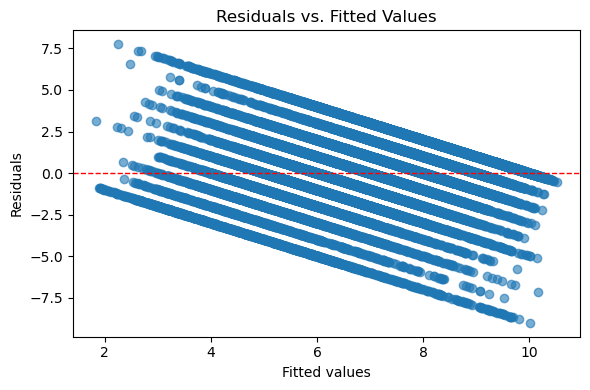

In [41]:
# Residuals vs. fitted values
fitted_train = ols_model.fittedvalues
residuals = ols_model.resid
plt.figure(figsize=(6, 4))
plt.scatter(fitted_train, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values")
plt.tight_layout()
plt.show()

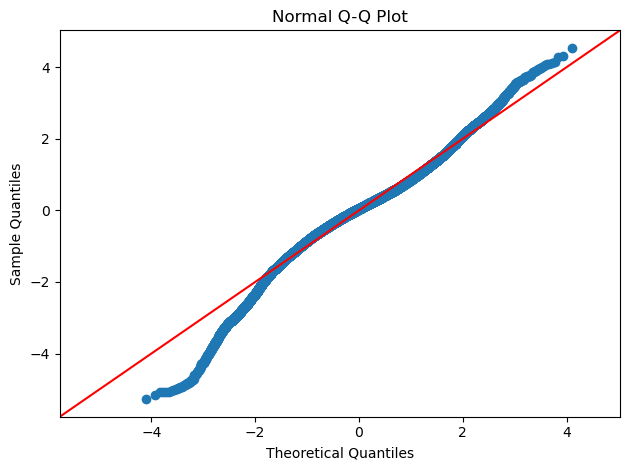

In [ ]:
# Normal Q-Q plot of studentized residuals
influence = ols_model.get_influence()
studentized_residuals = influence.resid_studentized_internal
sm.qqplot(studentized_residuals, line="45", fit=True)
plt.title("Normal Q-Q Plot")
plt.tight_layout()
plt.show()

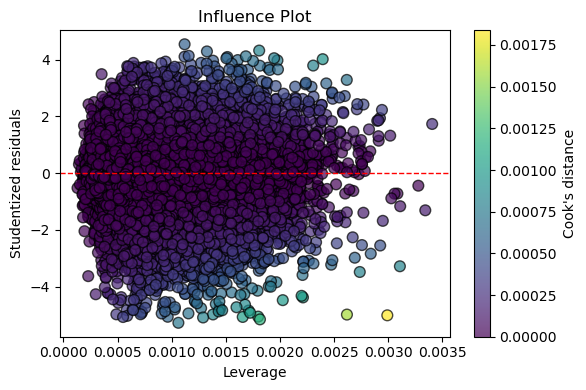

In [45]:
# Leverage vs. studentized residuals with Cook's distance
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]
n_obs = X_train_sm.shape[0]
plt.figure(figsize=(6, 4))
plt.scatter(leverage, studentized_residuals, c=cooks_d, cmap="viridis", s=60, edgecolor="k", alpha=0.7)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Leverage")
plt.ylabel("Studentized residuals")
plt.title("Influence Plot")
plt.colorbar(label="Cook's distance")
plt.tight_layout()
plt.show()

## Ridge and Lasso Regressions

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd


# Standardize predictors for regularized regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Search candidate penalties on a log grid
alphas = np.logspace(-3, 3, 50)

# Ridge with 10-fold CV
ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)

# Lasso with 10-fold CV
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)


ridge_test_pred = ridge_cv.predict(X_test_scaled)
lasso_test_pred = lasso_cv.predict(X_test_scaled)


ridge_results = {
    "model": "Ridge",
    "alpha": ridge_cv.alpha_,
    "train_MSE": mean_squared_error(y_train, ridge_cv.predict(X_train_scaled)),
    "test_MSE": mean_squared_error(y_test, ridge_test_pred),
    "test_RMSE": np.sqrt(mean_squared_error(y_test, ridge_test_pred)),
    "n_nonzero_coefficients": np.sum(np.abs(ridge_cv.coef_) > 1e-8),
}


lasso_results = {
    "model": "Lasso",
    "alpha": lasso_cv.alpha_,
    "train_MSE": mean_squared_error(y_train, lasso_cv.predict(X_train_scaled)),
    "test_MSE": mean_squared_error(y_test, lasso_test_pred),
    "test_RMSE": np.sqrt(mean_squared_error(y_test, lasso_test_pred)),
    "n_nonzero_coefficients": np.sum(np.abs(lasso_cv.coef_) > 1e-8),
}


regularization_summary = pd.DataFrame([ridge_results, lasso_results])
display(regularization_summary.sort_values("test_MSE"))

,model,alpha,train_MSE,test_MSE,test_RMSE,n_nonzero_coefficients
1,Lasso,0.003089,2.916214,2.889343,1.699807,36
0,Ridge,184.206997,2.915751,2.891044,1.700307,40


# Random Forest


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import numpy as np


rf_regressor = RandomForestRegressor(
    n_estimators=500,
    max_features=13,
    random_state=42,
    n_jobs=-1,
    oob_score=False,
    min_samples_leaf=2,
    bootstrap=True,
    max_depth=None,
    min_samples_split=2,
    criterion="squared_error",
)


cv_results = cross_validate(
    rf_regressor,
    X_train,
    y_train,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
    error_score="raise",
)


cv_mse = -cv_results["test_score"]
cv_rmse = np.sqrt(cv_mse)
print(f"CV MSE (mean ± std): {cv_mse.mean():.3f} ± {cv_mse.std():.3f}")
print(f"CV RMSE (mean ± std): {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f}")


rf_regressor.fit(X_train, y_train)
rf_test_pred = rf_regressor.predict(X_test)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
rf_test_rmse = np.sqrt(rf_test_mse)
print(f"Test MSE: {rf_test_mse:.3f}")
print(f"Test RMSE: {rf_test_rmse:.3f}")

CV MSE (mean ± std): 2.789 ± 0.060
CV RMSE (mean ± std): 1.670 ± 0.018
Test MSE: 2.771
Test RMSE: 1.665
Test MSE: 2.771
Test RMSE: 1.665


,feature,importance
1,FinSat,0.261468
5,FreeChoice,0.154015
0,SHealth,0.044406
10,Democracy,0.040824
2,FinSat_ComParent,0.028765
32,ReligiousAttendance,0.028094
33,Pray,0.022966
31,GodImportance,0.022762
6,Security,0.021926
11,HumanRights,0.018947


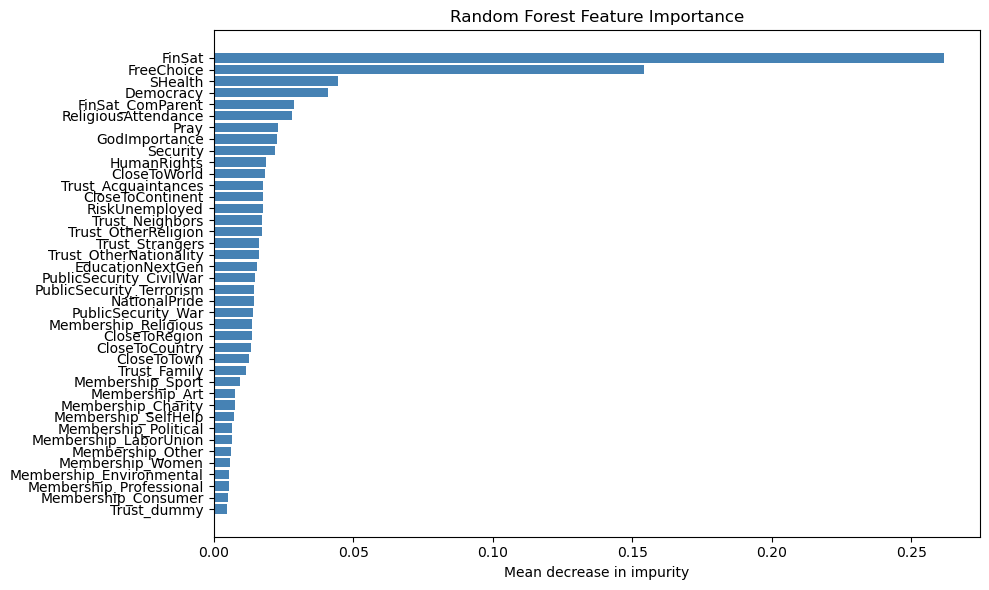

Exception ignored in: <function ResourceTracker.__del__ at 0x105965bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102df1bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1080d1bc0>
Traceback (most recent call last

In [59]:
# Plot feature importance

import pandas as pd

feature_importance = pd.DataFrame(
    {
        "feature": predictor_cols,
        "importance": rf_regressor.feature_importances_,
    }
).sort_values("importance", ascending=False)

display(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# Refit the full dataset with Random Forest
Given the lowest test MSE given by the Cross-Validated Random Forest (CV-RF) model, we will now proceed to fit the full dataset (*n* = 60806) using the CV-RF model, with the aim of maximizing the use of observations.

,feature,importance
1,FinSat,0.261576
5,FreeChoice,0.153860
0,SHealth,0.045781
10,Democracy,0.040756
2,FinSat_ComParent,0.028434
32,ReligiousAttendance,0.027823
33,Pray,0.022966
31,GodImportance,0.022836
6,Security,0.021678
11,HumanRights,0.018830


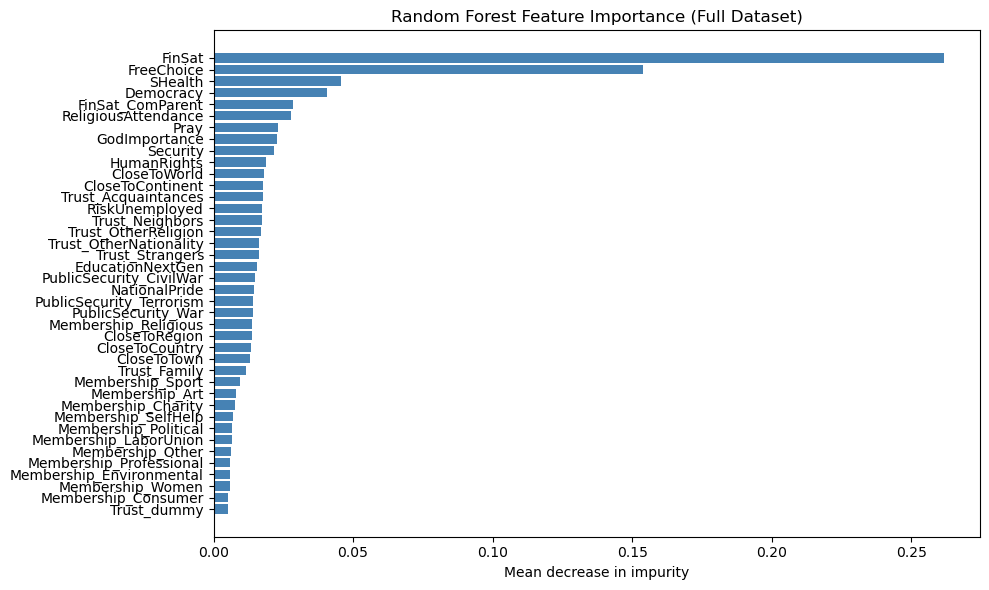

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

# Refit the tuned random forest using all available observations
rf_regressor_full = RandomForestRegressor(
    n_estimators=500,
    max_features=13,
    random_state=42,
    n_jobs=-1,
    oob_score=False,
    min_samples_leaf=2,
    bootstrap=True,
    max_depth=None,
    min_samples_split=2,
    criterion="squared_error",
)

rf_regressor_full.fit(X, y)

full_feature_importance = pd.DataFrame(
    {
        "feature": predictor_cols,
        "importance": rf_regressor_full.feature_importances_,
    }
).sort_values("importance", ascending=False)

display(full_feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(full_feature_importance["feature"], full_feature_importance["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance (Full Dataset)")
plt.tight_layout()
plt.savefig("../output/rf_reg_feature_importance_full.png")
plt.show()

# Discretization of DV
We also explore the results when we discretize the DV `LifeSat` into three bins:
- Unsatisfied: Scores 1–4
- Somewhat satisfied: Scores 5–7
- Highly satisfied: Scores 8–10

In [66]:
lifeSat_bins = pd.cut(
    model_data["LifeSat"],
    bins=[0, 4, 7, 10],
    labels=["Unsatisfied", "Somewhat satisfied", "Highly satisfied"],
    include_lowest=True,
    right=True,
    ordered=True,
 )
lifesat_idx = model_data.columns.get_loc("LifeSat")
if "LifeSat_binned" not in model_data.columns:
    model_data.insert(lifesat_idx + 1, "LifeSat_binned", lifeSat_bins)
else:
    model_data["LifeSat_binned"] = lifeSat_bins
print("LifeSat_binned counts:")
print(model_data["LifeSat_binned"].value_counts().sort_index())

# Save the updated model data with binned LifeSat
model_data.to_csv(DATA_PATH.parent / "lifesat_sdt_model_data_binned.csv", index=False)

LifeSat_binned counts:
LifeSat_binned
Unsatisfied            6877
Somewhat satisfied    24117
Highly satisfied      29812
Name: count, dtype: int64


## Multinomial Logistic Regression

In [70]:
from statsmodels.discrete.discrete_model import MNLogit

# Align the categorical outcome with X_train indices
y_train_mult = model_data.loc[X_train.index, "LifeSat_binned"].astype("category")
category_order = list(y_train_mult.cat.categories)
print("MNLogit category order:", category_order)

train_valid_idx = y_train_mult.dropna().index
X_train_mult = X_train.loc[train_valid_idx]
y_train_mult = y_train_mult.loc[train_valid_idx]
X_train_mult_sm = sm.add_constant(X_train_mult, has_constant="add")
y_train_codes = y_train_mult.cat.codes

mnlogit_model = MNLogit(y_train_codes, X_train_mult_sm)
mnlogit_result = mnlogit_model.fit(method="newton", maxiter=100, disp=False)
print(mnlogit_result.summary())

MNLogit category order: ['Unsatisfied', 'Somewhat satisfied', 'Highly satisfied']
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                48644
Model:                        MNLogit   Df Residuals:                    48562
Method:                           MLE   Df Model:                           80
Date:                Mon, 17 Nov 2025   Pseudo R-squ.:                  0.2291
Time:                        10:00:21   Log-Likelihood:                -36125.
converged:                       True   LL-Null:                       -46862.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.4799      0.182    -19.172      0.000      -3.836      -3.124
SHealth

,metric,value
0,accuracy,0.669051
1,weighted_f1,0.660131
2,matthews_corrcoef,0.419539
3,roc_auc_weighted,0.800026


AUC (Unsatisfied vs rest): 0.862
AUC (Somewhat satisfied vs rest): 0.752
AUC (Highly satisfied vs rest): 0.825


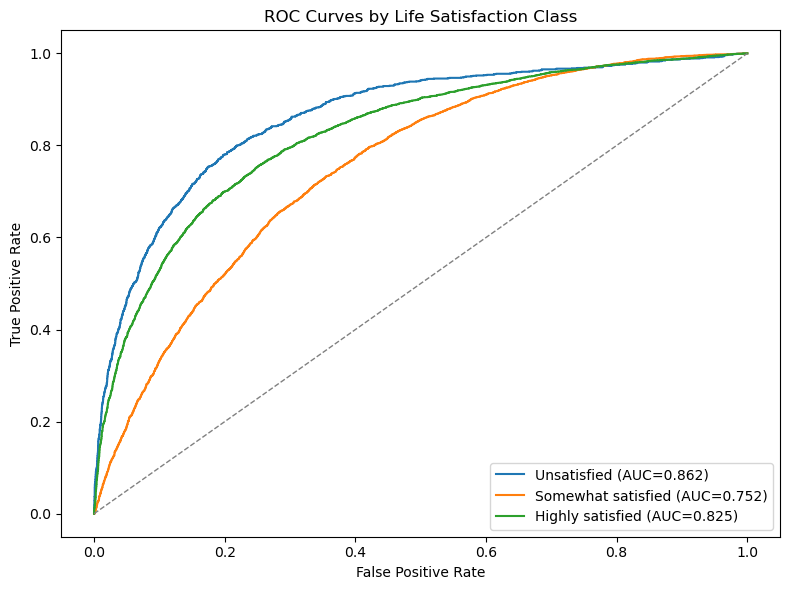


ROC curve points for Unsatisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000740,0.941060
2,0.000000,0.006657,0.891153
3,0.000093,0.006657,0.884832
4,0.000093,0.011095,0.869320



ROC curve points for Somewhat satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000137,0.000000,0.792302
2,0.000547,0.000000,0.757670
3,0.000547,0.000206,0.755508
4,0.000820,0.000206,0.746924



ROC curve points for Highly satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000168,0.967467
2,0.000000,0.003353,0.956045
3,0.000161,0.003353,0.955915
4,0.000161,0.005868,0.952028


In [75]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Prepare test set for evaluation
y_test_mult = model_data.loc[X_test.index, "LifeSat_binned"].astype("category")
y_test_mult = y_test_mult.cat.set_categories(category_order, ordered=True)

test_valid_idx = y_test_mult.dropna().index
X_test_mult = X_test.loc[test_valid_idx]
y_test_mult = y_test_mult.loc[test_valid_idx]
X_test_mult_sm = sm.add_constant(X_test_mult, has_constant="add")
y_test_codes = y_test_mult.cat.codes

test_probabilities = mnlogit_result.predict(X_test_mult_sm)
pred_codes = test_probabilities.to_numpy().argmax(axis=1)

accuracy = accuracy_score(y_test_codes, pred_codes)
weighted_f1 = f1_score(y_test_codes, pred_codes, average="weighted")
mcc = matthews_corrcoef(y_test_codes, pred_codes)

y_test_binarized = label_binarize(y_test_codes, classes=range(len(category_order)))
roc_auc_weighted = roc_auc_score(
    y_test_binarized,
    test_probabilities.to_numpy(),
    average="weighted",
    multi_class="ovr",
)
roc_auc_per_class = roc_auc_score(
    y_test_binarized,
    test_probabilities.to_numpy(),
    average=None,
    multi_class="ovr",
)

metrics_summary = pd.DataFrame(
    {
        "metric": ["accuracy", "weighted_f1", "matthews_corrcoef", "roc_auc_weighted"],
        "value": [accuracy, weighted_f1, mcc, roc_auc_weighted],
    }
)
display(metrics_summary)

for class_name, auc_val in zip(category_order, roc_auc_per_class):
    print(f"AUC ({class_name} vs rest): {auc_val:.3f}")

roc_curves = {}
plt.figure(figsize=(8, 6))
for class_idx, class_name in enumerate(category_order):
    fpr, tpr, thresholds = roc_curve(
        y_test_binarized[:, class_idx],
        test_probabilities.to_numpy()[:, class_idx],
    )
    roc_curves[class_name] = pd.DataFrame(
        {
            "fpr": fpr,
            "tpr": tpr,
            "threshold": thresholds,
        }
)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC={roc_auc_per_class[class_idx]:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="grey", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Life Satisfaction Class")
plt.legend()
plt.tight_layout()
plt.savefig("../output/roc_curves_lifesat_multinomial.png")
plt.show()

# Save the plotted ROC curves figure
output_dir = Path("../output/")
output_dir.mkdir(parents=True, exist_ok=True)

for class_name, curve_df in roc_curves.items():
    print(f"\nROC curve points for {class_name} (first 5 rows):")
    display(curve_df.head())

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
 )
from sklearn.preprocessing import label_binarize

# Prepare training data with valid LifeSat_binned labels
y_train_class = model_data.loc[X_train.index, "LifeSat_binned"].astype("category") # type: ignore
train_valid_idx = y_train_class.dropna().index
X_train_class = X_train.loc[train_valid_idx]
y_train_class = y_train_class.loc[train_valid_idx]
category_order = list(y_train_class.cat.categories)

rf_classifier = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="sqrt",    # typically used for classification
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
 )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ["accuracy", "f1_weighted"]

cv_results_clf = cross_validate(
    rf_classifier,
    X_train_class,
    y_train_class,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
 )

cv_summary = pd.DataFrame({
    "metric": scoring,
    "train_mean": [cv_results_clf[f"train_{metric}"].mean() for metric in scoring],
    "train_std": [cv_results_clf[f"train_{metric}"].std() for metric in scoring],
    "test_mean": [cv_results_clf[f"test_{metric}"].mean() for metric in scoring],
    "test_std": [cv_results_clf[f"test_{metric}"].std() for metric in scoring],
}).round(3)
display(cv_summary)

rf_classifier.fit(X_train_class, y_train_class)
feature_importance_clf = pd.Series(
    rf_classifier.feature_importances_, index=X_train_class.columns
 ).sort_values(ascending=False)
display(feature_importance_clf.head(10).to_frame(name="importance"))

# Evaluate on held-out test set for context
y_test_class = model_data.loc[X_test.index, "LifeSat_binned"].astype("category")
y_test_class = y_test_class.cat.set_categories(category_order, ordered=True)
test_valid_idx = y_test_class.dropna().index
X_test_class = X_test.loc[test_valid_idx]
y_test_class = y_test_class.loc[test_valid_idx]

test_probabilities = rf_classifier.predict_proba(X_test_class)
proba_df = pd.DataFrame(
    test_probabilities,
    columns=rf_classifier.classes_,
    index=X_test_class.index
).reindex(columns=category_order, fill_value=0.0)
test_predictions = pd.Categorical(
    rf_classifier.predict(X_test_class), categories=category_order, ordered=True
 )

y_test_codes = y_test_class.cat.codes
accuracy = accuracy_score(y_test_class, test_predictions)
weighted_f1 = f1_score(y_test_class, test_predictions, average="weighted", zero_division=0)
mcc = matthews_corrcoef(y_test_class, test_predictions)

y_test_binarized = label_binarize(y_test_codes, classes=range(len(category_order)))
roc_auc_weighted = roc_auc_score(
    y_test_binarized,
    proba_df.to_numpy(),
    average="weighted",
    multi_class="ovr",
 )
roc_auc_per_class = roc_auc_score(
    y_test_binarized,
    proba_df.to_numpy(),
    average=None,
    multi_class="ovr",
 )

metrics_summary = pd.DataFrame(
    {
        "metric": ["accuracy", "weighted_f1", "matthews_corrcoef", "roc_auc_weighted"],
        "value": [accuracy, weighted_f1, mcc, roc_auc_weighted],
    }
 )
display(metrics_summary)

for class_name, auc_val in zip(category_order, roc_auc_per_class):
    print(f"AUC ({class_name} vs rest): {auc_val:.3f}")

print("Random Forest classification report (test set):")
print(
    classification_report(
        y_test_class, test_predictions, target_names=category_order, zero_division=0
    )
)

# Confusion matrix with totals
confusion_df = pd.crosstab(
    y_test_class,
    test_predictions,
    rownames=["Actual"],
    colnames=["Predicted"],
    dropna=False,
 ).reindex(index=category_order, columns=category_order, fill_value=0)
confusion_df["Total"] = confusion_df.sum(axis=1)
total_row = pd.DataFrame(confusion_df.sum(axis=0)).T
total_row.index = ["Total"]
confusion_with_totals = pd.concat([confusion_df, total_row])
display(confusion_with_totals)

,metric,train_mean,train_std,test_mean,test_std
0,accuracy,0.976,0.0,0.689,0.005
1,f1_weighted,0.975,0.0,0.681,0.005


,importance
FinSat,0.182421
FreeChoice,0.132721
Democracy,0.046564
SHealth,0.036141
ReligiousAttendance,0.032376
GodImportance,0.031300
Pray,0.030315
FinSat_ComParent,0.024619
CloseToWorld,0.022957
RiskUnemployed,0.022762


,metric,value
0,accuracy,0.694540
1,weighted_f1,0.686605
2,matthews_corrcoef,0.465681
3,roc_auc_weighted,0.828129


AUC (Unsatisfied vs rest): 0.878
AUC (Somewhat satisfied vs rest): 0.791
AUC (Highly satisfied vs rest): 0.847
Random Forest classification report (test set):
                    precision    recall  f1-score   support

       Unsatisfied       0.74      0.79      0.77      5965
Somewhat satisfied       0.64      0.67      0.66      4845
  Highly satisfied       0.66      0.33      0.44      1352

          accuracy                           0.69     12162
         macro avg       0.68      0.60      0.62     12162
      weighted avg       0.69      0.69      0.69     12162



Predicted,Unsatisfied,Somewhat satisfied,Highly satisfied,Total
Unsatisfied,445,688,219,1352
Somewhat satisfied,155,3266,1424,4845
Highly satisfied,75,1154,4736,5965
Total,675,5108,6379,12162


Exception ignored in: <function ResourceTracker.__del__ at 0x106a9dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107471bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107471bc0>
Traceback (most recent call last

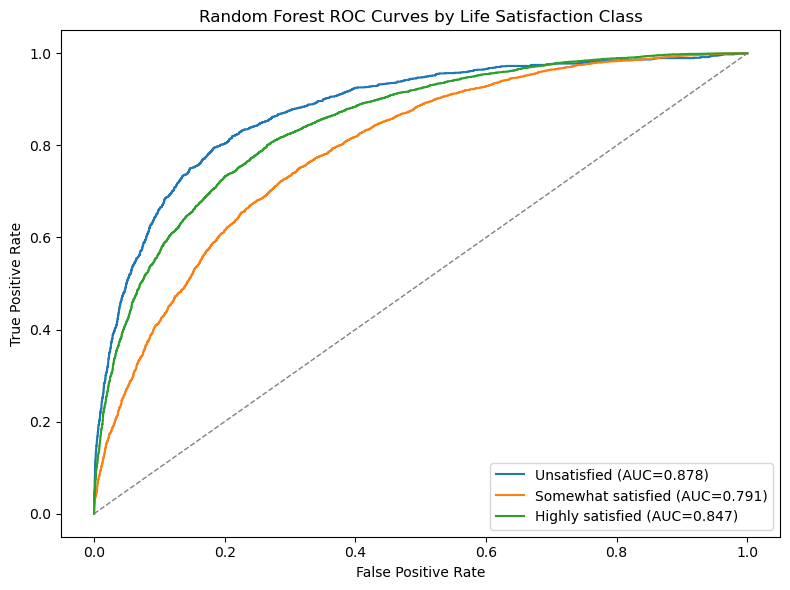


ROC curve points for Unsatisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000740,0.915542
2,0.000000,0.025888,0.777973
3,0.000093,0.025888,0.776442
4,0.000093,0.031065,0.760240



ROC curve points for Somewhat satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.0,0.000000,inf
1,0.0,0.001032,0.999084
2,0.0,0.001445,0.990101
3,0.0,0.001651,0.970651
4,0.0,0.002064,0.968138



ROC curve points for Highly satisfied (first 5 rows):


,fpr,tpr,threshold
0,0.000000,0.000000,inf
1,0.000000,0.000168,0.999714
2,0.000000,0.006203,0.975976
3,0.000161,0.006203,0.974774
4,0.000161,0.015088,0.961959


Exception ignored in: <function ResourceTracker.__del__ at 0x1045e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1042e9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104901bc0>
Traceback (most recent call last

In [ ]:
from sklearn.metrics import roc_curve

# Plot ROC curves for the random forest classifier
roc_curves_rf: dict[str, pd.DataFrame] = {}
roc_auc_per_class_rf = roc_auc_score(
    y_test_binarized, proba_df.to_numpy(), average=None, multi_class="ovr"
 )

fig, ax = plt.subplots(figsize=(8, 6))
for class_idx, class_name in enumerate(category_order):
    fpr, tpr, thresholds = roc_curve(
        y_test_binarized[:, class_idx], proba_df.to_numpy()[:, class_idx]
    )
    roc_curves_rf[class_name] = pd.DataFrame(
        {"fpr": fpr, "tpr": tpr, "threshold": thresholds}
    )
    ax.plot(
        fpr,
        tpr,
        label=f"{class_name} (AUC={roc_auc_per_class_rf[class_idx]:.3f})",
    )

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Random Forest ROC Curves by Life Satisfaction Class")
ax.legend()
fig.tight_layout()

output_dir = Path("../output/")
output_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(output_dir / "roc_curves_random_forest.png")
plt.show()

for class_name, curve_df in roc_curves_rf.items():
    print(f"\nROC curve points for {class_name} (first 5 rows):")
    display(curve_df.head())

## Refit the full dataset with Random Forest
Because of the slightly better classification performance by the Cross-Validated Random Forest model, we will fit the full dataset (*n* = 60806) using the random forest model.

Refitting random forest classifier on 60806 observations and 40 predictors.


,feature,importance
0,FinSat,0.181100
1,FreeChoice,0.133366
2,Democracy,0.046355
3,SHealth,0.036688
4,ReligiousAttendance,0.032582
5,GodImportance,0.031192
6,Pray,0.030199
7,FinSat_ComParent,0.025045
8,CloseToWorld,0.022949
9,RiskUnemployed,0.022810


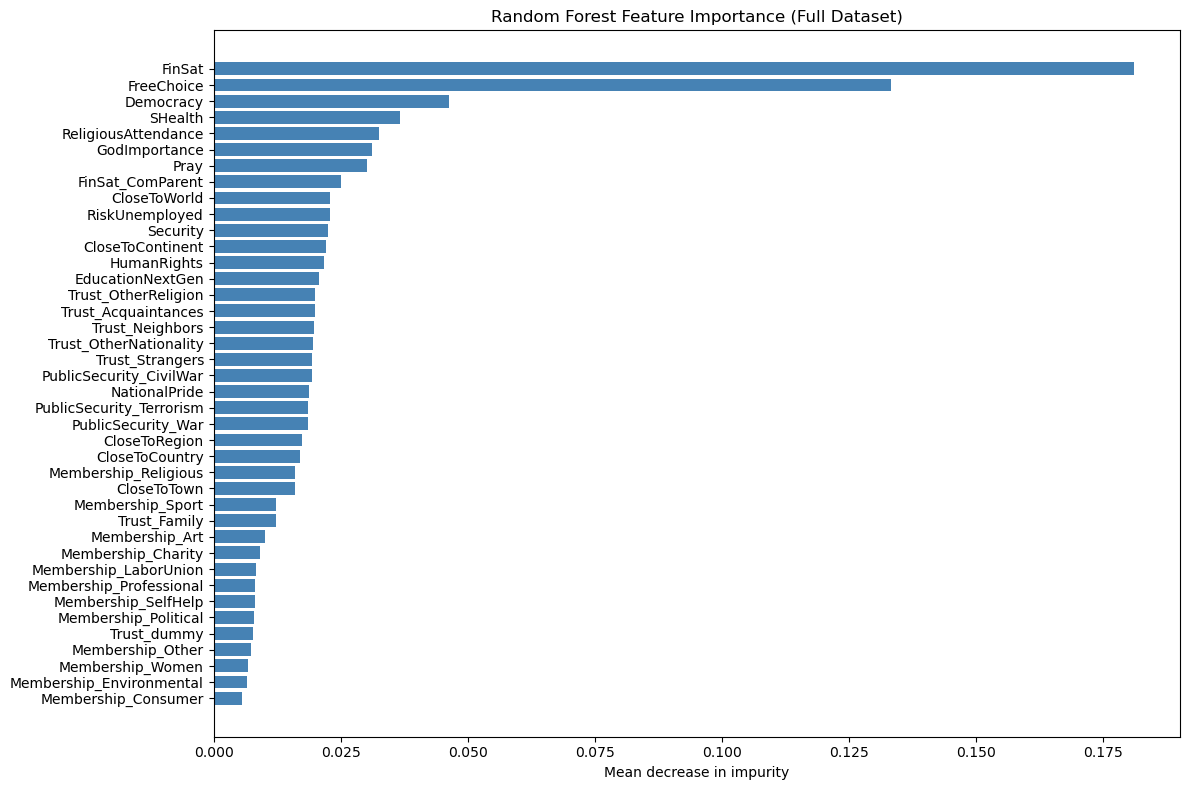

In [82]:
# Refit the tuned random forest classifier on the full dataset
model_data_class = model_data.dropna(subset=["LifeSat_binned"]).copy()
X_full_class = model_data_class[predictor_cols]
y_full_class = model_data_class["LifeSat_binned"].astype("category")
category_order_full = list(y_full_class.cat.categories)

print(
    f"Refitting random forest classifier on {X_full_class.shape[0]} observations and "
    f"{X_full_class.shape[1]} predictors."
 )

rf_classifier_full = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
    bootstrap=True,
 )
rf_classifier_full.fit(X_full_class, y_full_class)

feature_importance_full = pd.DataFrame(
    {
        "feature": X_full_class.columns,
        "importance": rf_classifier_full.feature_importances_,
    }
).sort_values("importance", ascending=False).reset_index(drop=True)
display(feature_importance_full)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_full["feature"], feature_importance_full["importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in impurity")
plt.title("Random Forest Feature Importance (Full Dataset)")
plt.tight_layout()
plt.savefig("../output/rf_class_feature_importance_full.png")
plt.show()